## Train word2vec from raw article IV reports using Gensim

#### Terminologies:
1. raw_doc: unprocessed raw document from txt file

#### Features:
1. filter out certain punctuations
2. replace numeric values with "numeric_value"
3. choose embedding size of 100 due to small corpus size

### Load dictionary and pre-built functions

In [4]:
import sys
import os

import re
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import matplotlib.pyplot as plt

import gensim
import spacy
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases

In [2]:
## global folder path 
data_folder = '../../data/'
model_folder = '../../model/'
raw_data_path = os.path.join(data_folder,'raw/article_IV_corpus.txt')
data_processed_folder = os.path.join(data_folder,'processed')
results_folder = os.path.join(data_folder,'results','topic_model_results')

nlp = spacy.load('en')
#nlp.pipeline = [nlp.tagger, nlp.sentencizer]

### Load and process original text using spacy

In [3]:
with open(raw_data_path,'r',encoding='utf8') as f:
    raw_doc = f.readlines()
    raw_doc = [l.strip(' \n') for l in raw_doc if len(l)>50]

print('Length of raw documents {}'.format(len(raw_doc)))

Length of raw documents 142564


In [99]:
def clean_sentence(sent):
    '''remove punctuations in sentences
       and reduce to lemma form'''
    
    sent = [word.lemma_ for word in sent if word.pos_ not in ('PUNCT')]
    sent = [re.sub('[0-9]*.*[0-9]','numeric_value', word) for word in sent]
    
    return sent


def prepare_data(raw_doc):
    '''filter and lemmantize using spacy'''
    lemma_doc = []
    
    for paragraph in raw_doc:        
        doc = nlp(paragraph)
        sents = list(doc.sents)
        sentence = list(map(lambda x: clean_sentence(x), sents))
        lemma_doc.append(sentence)
    
    ## flatten
    lemma_doc = [s for l in lemma_doc for s in l ]

    return lemma_doc

start_time = time.time()
processed_doc = prepare_data(raw_doc = raw_doc)
print("--{} seconds --".format(time.time()- start_time))

--2253.9872109889984 seconds --


In [127]:
pickle_out = open(os.path.join(data_processed_folder,'processed_doc_for_word2vec_training.p'),"wb")
pickle.dump(processed_doc, pickle_out)
pickle_out.close()

### Train w2v model using gensim

In [3]:
# Load Pre-processed document list
processed_doc = pickle.load( open(os.path.join(data_processed_folder,'processed_doc_for_word2vec_training.p') , "rb" ) )

In [5]:
bigram_transformer = Phrases(processed_doc)

#### initialize model and build vocabulary 

In [12]:
n_dim = 100
window = 7 
downsampling = 1e-5
seed = 1
num_workers = os.cpu_count()    ## not sure if this is a good idea
min_count = 30 

aiv_w2v = Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=n_dim,
    min_count=min_count,
    window= window,
    sample=downsampling
)

## build the vocabulary
aiv_w2v.build_vocab(bigram_transformer[processed_doc])
corpus_count = aiv_w2v.corpus_count

#### train w2v model 

In [13]:
iteration = 10

start_time = time.time()

if gensim.__version__[0] =='1':
    aiv_w2v.train(bigram_transformer[processed_doc])
else:
    aiv_w2v.train(bigram_transformer[processed_doc], total_examples=corpus_count, epochs = iteration)
    
print("--{} seconds --".format(time.time()- start_time))

--621.2975976467133 seconds --


#### save model

In [14]:
## save trained word2 to vect model 
aiv_w2v.save(os.path.join(model_folder,'word2vec','aiv_bigram.w2v'))

#### test

In [15]:
model = aiv_w2v.wv
vocabs = model.vocab.keys()
model.most_similar('corruption',topn=20)

[('fight_corruption', 0.8043781518936157),
 ('anti_corruption', 0.799119234085083),
 ('anticorruption', 0.7803606986999512),
 ('bureaucracy', 0.7692206501960754),
 ('combat_corruption', 0.7689897418022156),
 ('fight_against', 0.7650812268257141),
 ('prosecute', 0.7344725131988525),
 ('judiciary', 0.7245585918426514),
 ('red_tape', 0.724105954170227),
 ('prosecution', 0.7094104290008545),
 ('rent_seeking', 0.7072718143463135),
 ('investigation', 0.7034107446670532),
 ('crime', 0.7014716863632202),
 ('fraud', 0.6992028951644897),
 ('judicial_system', 0.6923291087150574),
 ('rent_seek', 0.6596778035163879),
 ('tax_evasion', 0.6594765186309814),
 ('deep_root', 0.6574211120605469),
 ('governance', 0.6516907811164856),
 ('bureaucratic', 0.6511675119400024)]

In [16]:
len(vocabs)

8691

#### visualization

In [21]:
X = model[vocabs]

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=11, whiten=True)
clf = pca.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocabs, columns=['x', 'y', 'z'])

tmp.head(3)

,x,y,z
<_title,-0.006071,0.399108,2.141831
>,-0.063902,0.515567,1.703382
context,0.341786,-0.382894,0.546560


In [26]:
tmp = tmp.sample(100)

Text(0.5,0.92,'aiv_w2v map - PCA')

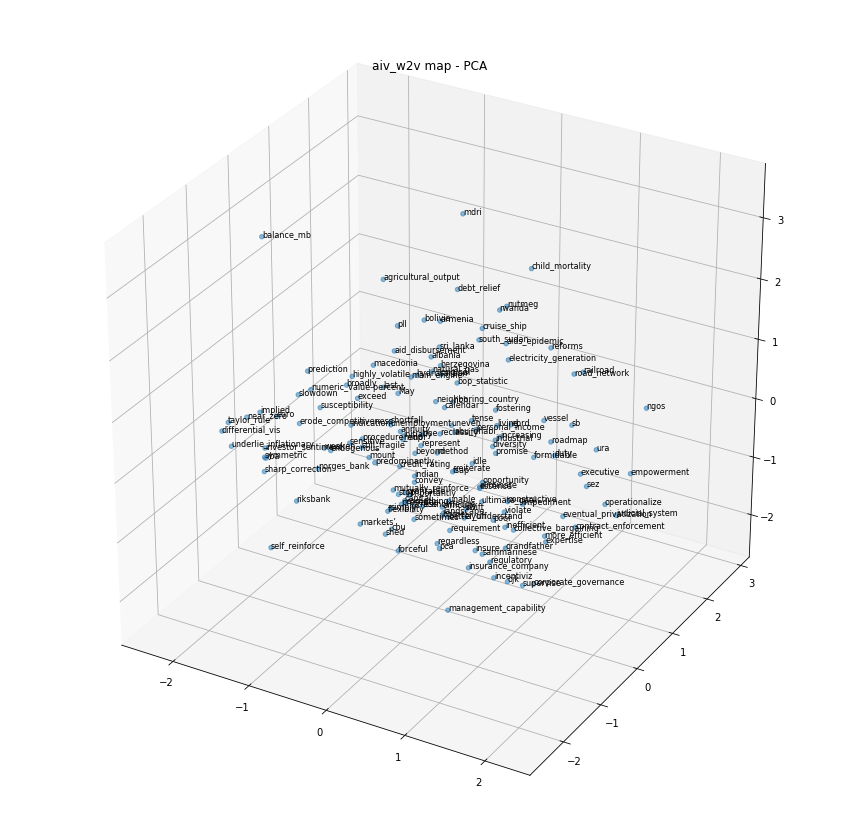

In [30]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=8, zorder=1, color='k')
    
plt.title('aiv_w2v map - PCA')
#plt.show()

In [ ]:
## Plot t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=11)

clf = tsne.fit_transform(X)

Text(0.5,0.92,'aiv_w2v map - t-SNE')

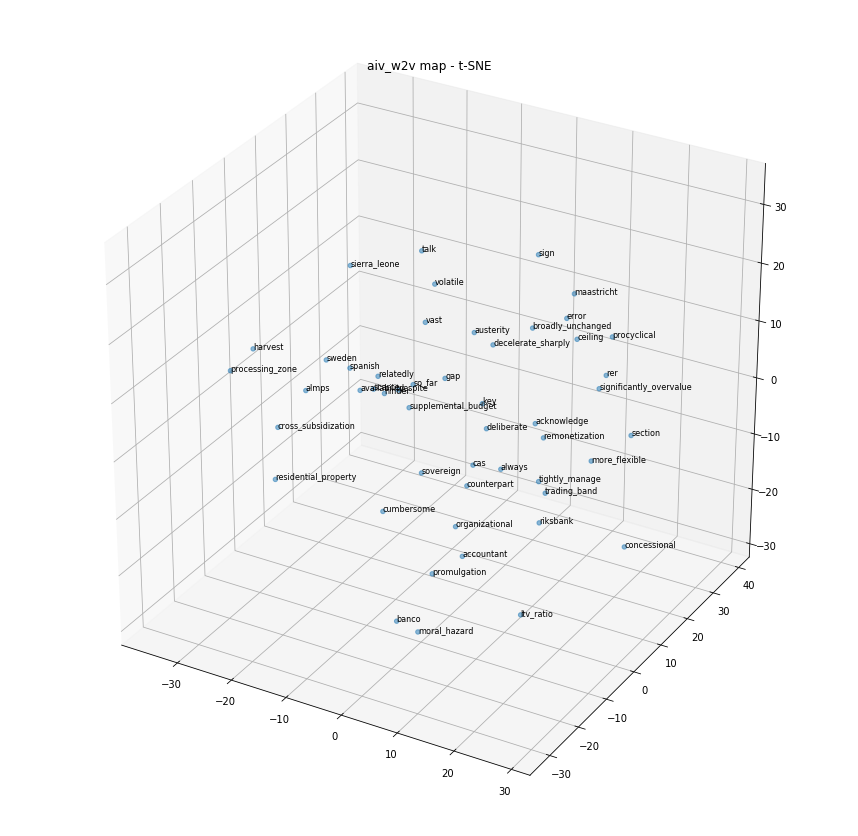

In [41]:
tmp = pd.DataFrame(clf, index=vocabs, columns=['x', 'y', 'z'])

tmp.head(3)

tmp = tmp.sample(50)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=8, zorder=1, color='k')
    
plt.title('aiv_w2v map - t-SNE')